In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datadata import utils
from prevision import *
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from IPython.display import display


In [3]:
hourly_sales = dataDir / "vente_hours.csv"
df_sales = pd.read_csv(hourly_sales).drop(['sources','periode','day'],axis=1)
df_sales['date_time'] = pd.to_datetime(df_sales['date_time']).dt.date
X=df_sales.values
listHours=["{:02d}:{:02d}".format(hour, minute) for hour in range(24) for minute in range(0, 60, 30)]
steps=24*2
ndays=len(X)//(steps)
print(f"computing {ndays} days from {df_sales['date_time'].min()} to {df_sales['date_time'].max()}")
newX=np.zeros((ndays,steps))
dt=[0]*ndays
for i in range(ndays):
    dt[i]=X[i*steps,0]
    newX[i]=X[i*steps:steps*(i+1),1]

computing 2490 days


# Analyse globale

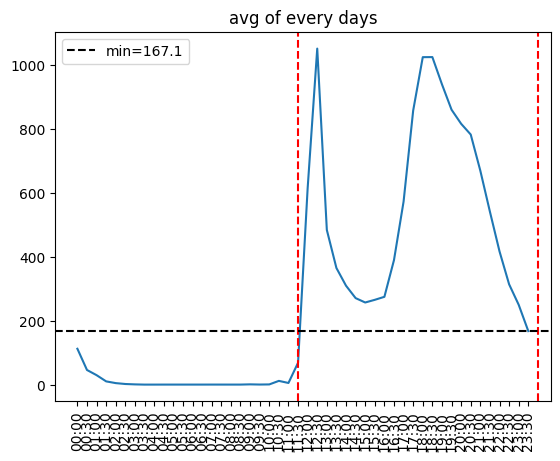

In [4]:
avgHours=np.mean(newX,0)
start_i = 23
end_i = 48

plt.plot(avgHours)
plt.xticks([i for i in range(len(listHours))],listHours,rotation=90)
plt.axvline(x=start_i, color='r', linestyle='--')
plt.axvline(x=end_i, color='r', linestyle='--')
minAvg=min(avgHours[start_i+1:end_i])
plt.axhline(y=minAvg, color='k', linestyle='--',label=f'min={minAvg:.1f}$')
plt.legend()
plt.title('avg of every days')
plt.show()

## Analyse par jours
### note : Jeudi ,vendredi, samedi le restaurant ferme à 23h, sinon à 22h.

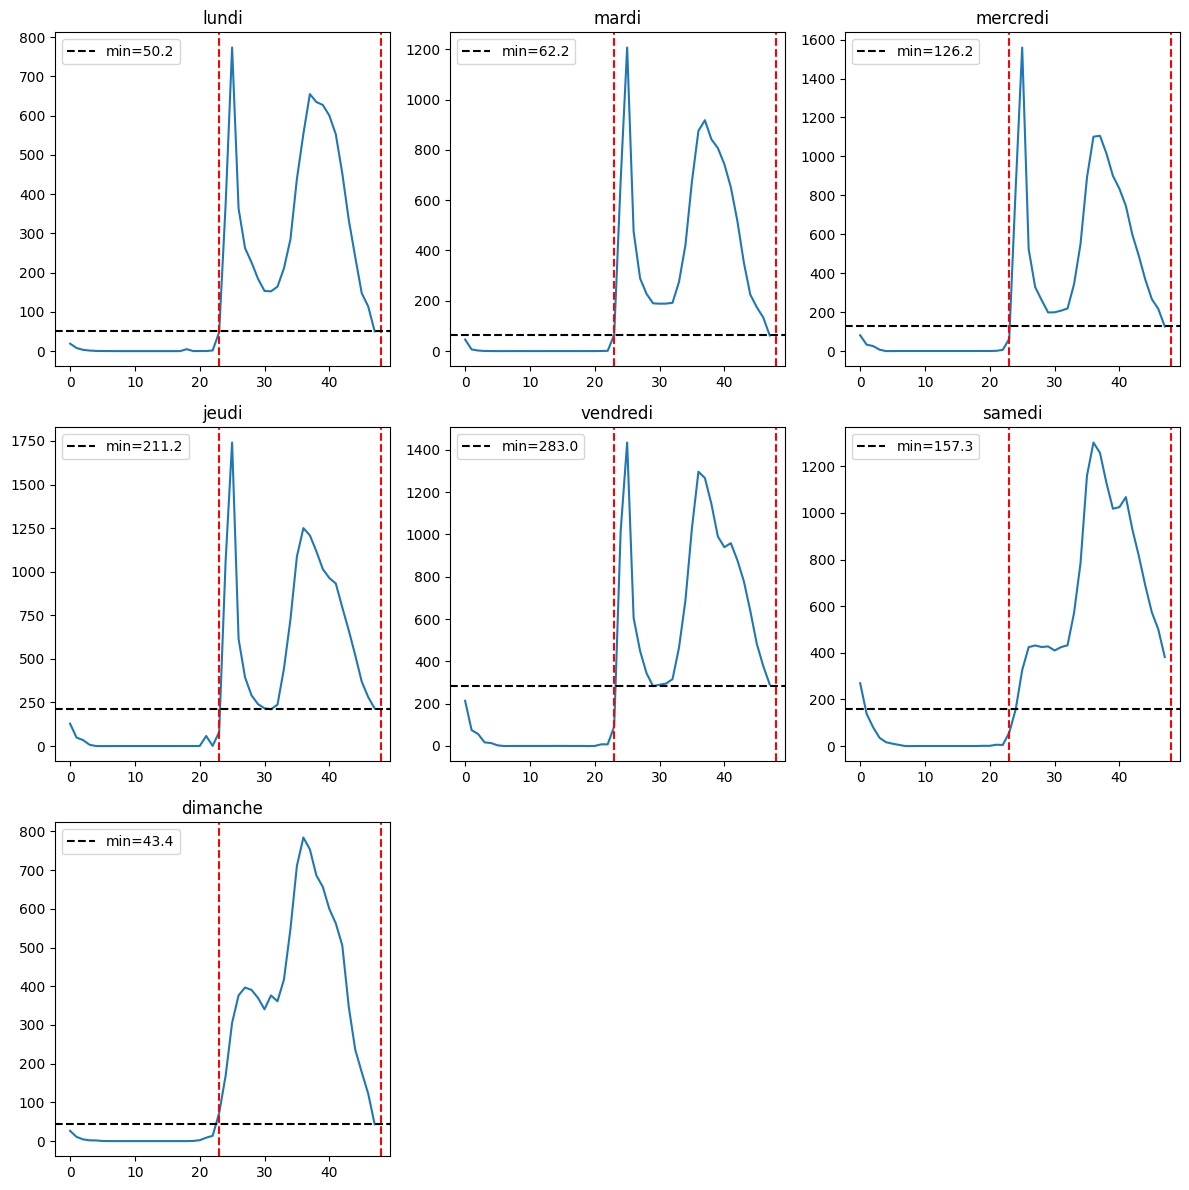

In [5]:
avgPerDays=np.zeros((steps,7))
freq=np.zeros((7))
weekday2str = {
    0: 'lundi',
    1: 'mardi',
    2: 'mercredi',
    3: 'jeudi',
    4: 'vendredi',
    5: 'samedi',
    6: 'dimanche'
}

for i in range(ndays):
    day=dt[i].weekday()
    freq[day]+=1
    avgPerDays[:,day]+=newX[i]
avgPerDays/=freq

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()
for i in range(7):
    ax = axes[i]
    ax.plot(avgPerDays[:,i])
    ax.set_title(f'{weekday2str[i]}')
    ax.axvline(x=start_i, color='r', linestyle='--')
    ax.axvline(x=end_i, color='r', linestyle='--')
    minAvg=min(avgPerDays[start_i+1:end_i,i])
    ax.axhline(y=minAvg, color='k', linestyle='--',label=f'min={minAvg:.1f}$')
    ax.legend()
    

for i in range(7, len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()

### Le restaurant ouvre à 11h30, on récupère uniquement les données utiles entre 11h30 et 23h30.

In [92]:
df_hourly=pd.DataFrame(newX[:,start_i:],columns=[f'h_{x}' for x in listHours[start_i:]])
df_hourly['date']=dt
df_hourly['date']= df_hourly['date'].astype('datetime64[ns]')
df_hourly.set_index('date',inplace=True)
df_hourly.head()

,h_11:30,h_12:00,h_12:30,h_13:00,h_13:30,h_14:00,h_14:30,h_15:00,h_15:30,h_16:00,...,h_19:00,h_19:30,h_20:00,h_20:30,h_21:00,h_21:30,h_22:00,h_22:30,h_23:00,h_23:30
date,,,,,,,,,,,,,,,,,,,,,
2016-10-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
2016-10-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
2016-10-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1433.20,1656.94,840.53,522.18,183.76,-24.58,0.00,0.0,0.00,0.00
2016-10-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
2016-10-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,956.53,1344.16,324.41,662.72,513.50,280.97,262.33,140.2,223.17,122.97


In [93]:
df_all,x,y=getAllDataFromCSV()
df_all.head()

,vente,apparent_temperature_max,apparent_temperature_min,sunset,uv_index_max,rain_sum,showers_sum,snowfall_sum,precipitation_hours,attendance_concerts,...,day_3,day_4,day_5,day_6,vacance,ferie,match_mma,match_nba,match_nfl,match_nhl
date,,,,,,,,,,,,,,,,,,,,,
2023-09-15,12222.69,20.1,8.0,19.10,5.40,0.00,0.0,0.0,0.0,0,...,False,True,False,False,0,False,0,0,0,0
2023-09-14,11244.54,14.5,11.4,19.13,3.90,0.00,0.0,0.0,0.0,0,...,True,False,False,False,0,False,0,0,0,0
2023-09-13,6514.32,23.4,15.2,19.17,4.75,36.75,0.0,0.0,4.0,0,...,False,False,False,False,0,False,1,0,0,0
2023-09-12,5708.35,23.9,14.5,19.18,4.55,0.00,0.0,0.0,0.0,0,...,False,False,False,False,0,False,1,0,0,0
2023-09-11,3031.55,23.4,15.5,19.22,5.65,0.00,0.0,0.0,0.0,0,...,False,False,False,False,0,False,0,0,0,0


In [96]:
temp_= df_all if 'vente' not in df_all else df_all.drop('vente',axis=1)
newDf_all = pd.merge(temp_,df_hourly,on='date')
newDf_all.head()
newDf_all.shape

(178, 52)